# Internet of Things (2IMN25)
### Machine Learning Assignment

### Introduction

The objective of the assignment is to use supervised machine learning techniques to make predictions about the net energy consumed based on the weather conditions. This will be accomplished by training a regression model on (real) data obtained from the weather sensor and energy meter over this year. This model will then be used to make predictions about the net energy consumption for data-points not *seen* by the model during training.

In [20]:
""" Import all libraries here """
import numpy as np
import os
import math
from datetime import datetime
import pandas as pd
from dateutil import parser
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

## Reading the dataset

In the code box below, please read in the data-sets into suitable data structures. The key task here would be to contruct the feature vectors which would be fed to the regression algorithm.

The datasets for the weather, rain and energy consumption have been provided in the zip file, extract this zip file into the same folder as the python notebook. The function should read both the weather and rainfall datafiles and create a merged feature vector array based on time-stamps.



In [40]:
def merge_weather_rain_data(data_path): # Select month for which data is collected
    """ 
    Reads in the CSV files for weather and rain data
    Merged them into a single array based on matching time-stamps
    
    """
        
    """ Read in the weather"""
    weatherFrame = pd.read_csv(os.path.join(data_path,'Weather-Eindhoven.csv'),
                             delimiter = ',',
                             header=0,
                             parse_dates = [0],
                             usecols = [0,1,2,4,6,7,8]) #Drop "chill", too many missing values
    weather_array  = weatherFrame.as_matrix()

    """ Read in the rain data"""
    rainFrame = pd.read_csv(os.path.join(data_path,'Rain-Best.csv'),
                             delimiter = ',',
                             header =  None,
                             skiprows = 1,
                             index_col = None,
                             parse_dates = [0]
                            )
    rain_array = rainFrame.as_matrix()

    """ Synchronize the 2 data-sets by removing the extra data from the rainfall dataset"""
    remove_rows = []
    for element,idx in zip(rain_array[:,0],range(len(rain_array[:,0]))):
        if element.minute%10 != 0:
            remove_rows.append(idx)

    synced_rain_array = np.delete(rain_array,remove_rows,axis = 0)

    print(synced_rain_array.shape)
    print(weather_array[:,0].shape)

    """ Merge the weather and rain data when time-stamps are equal """
    merged_array = []
    for rainElem in synced_rain_array:
        try :
            merged_row = []
            valid_row = list(weather_array[:,0]).index(rainElem[0])
            for weatherFeature in weather_array[valid_row]:
                merged_row.append(weatherFeature)
            merged_row.append(rainElem[1])
            merged_row.append(weather_array[valid_row][0].hour)
            merged_array.append(np.asarray(merged_row))
        except ValueError:
            print('Did not find matching timestamp in the weather data, continuing')
            continue

    merged_array = np.asarray(merged_array)
    return merged_array

# Create the merged array
data_path = os.path.join(os.getcwd(),'data')
merged_array = merge_weather_rain_data(data_path)

(43844, 2)
(43872,)
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matchin

## Cleaning the data

The datafiles may contain missing entries, in such an event, it is needed to get rid of such datapoints. The function should take in the created feature vector array and delete rows if features are missing.


In [43]:

def clean_up(merged_array):
    """ 
    Clean up the data by removing rows with missing data points 
    
    """
    missing_data_rows = []
    for row,idx in zip(merged_array,range(merged_array.shape[0])):
        for elem in row[1:]: #Timestamp,Description cannot be "checked"
            if pd.isnull(elem):
                missing_data_rows.append(idx)
                break # To prevent the same row from being added multiple times to the list, break when the first "nan" is found
    clean_data_array = np.delete(merged_array,missing_data_rows,axis=0)
    return clean_data_array

def filter_by_month(data_array,month):
    rows_delete = []
    for row,idx in zip(data_array,range(data_array.shape[0])):
        if row[0].month != month:
            rows_delete.append(idx)
    filtered_array = np.delete(data_array,rows_delete,axis=0)
    return filtered_array

clean_data_array = clean_up(merged_array)
month_array = filter_by_month(clean_data_array,month = 7)
print(month_array)

[[Timestamp('2017-07-01 00:00:00') 'lichte motregen' 15.5 ..., 1006.3
  0.27384200000000003 0]
 [Timestamp('2017-07-01 00:10:00') 'lichte motregen' 15.4 ..., 1006.3
  0.486968 0]
 [Timestamp('2017-07-01 00:20:00') 'motregen' 15.2 ..., 1006.3 1.154782 0]
 ..., 
 [Timestamp('2017-07-31 23:30:00') 'half bewolkt' 16.8 ..., 1013.7 0.000866
  23]
 [Timestamp('2017-07-31 23:40:00') 'half bewolkt' 16.8 ..., 1013.8 0.000866
  23]
 [Timestamp('2017-07-31 23:50:00') 'zwaar bewolkt' 16.8 ..., 1013.8
  0.0009310000000000001 23]]


## Reading in the energy values

The aim of the assignment is to predict the solar energy produced based on the weather conditions. Thus, for each weather datapoint, the solar energy must be calclulated using the energy datafiles and matching the time-stamps. Define a function that first creates a single datastructure from all the different energy files. Then, design a function that can perform an energy look-up based on the time-stamp of the weather data. This fucntion should return the total solar energy produced between the previous timestamp and current timestamp.Using this look-up function, loop over all the time-stamps of the weather data and generate energy labels. It should be noted, that for certain time-stamps, the energy values might be missing, datapoints corresponding to such timestamps must be deleted from the data array. 

*Hint : Check the documentation for the python package pandas to design a fast lookup function*

In [44]:
def create_dataframe(energyDir):
    """ Returns a dataframe that is formed by concatenating all the energy data files """
    fileList = []
    energyDir = os.path.join(os.getcwd(),energyDir)
    dirList = [os.path.join(energyDir, o) for o in os.listdir(energyDir) 
                    if os.path.isdir(os.path.join(energyDir,o))]
    
    sortedDirList = sorted(dirList)
    for direc in sortedDirList:
        dirFiles = [os.path.join(direc, f) for f in os.listdir(direc) 
                    if os.path.isfile(os.path.join(direc,f))]
        for f in dirFiles:
            fileList.append(f)
        
    fileList = sorted(fileList)
    frame = pd.DataFrame()
    frameList = []
    for f in fileList:
        try:
            df = pd.read_csv(f,index_col=None, header=None,parse_dates=[[0,1]],skipfooter=2)
            frameList.append(df)
        except:
            continue
    frame = pd.concat(frameList)
    sparseFrame = frame.drop([2,3,4,5,6,7,8,9,13],axis=1)
    sparseFrame.columns = ['TimeStamp','Energy Consumed','Energy Produced','Solar Energy Produced']
    return sparseFrame
    
def energy_frame_month(energyDir,month):
    energyDir = os.path.join(os.getcwd(),energyDir)
    monthDir = os.path.join(energyDir,'0{}'.format(month))
    dirFiles = [os.path.join(monthDir, f) for f in os.listdir(monthDir) 
                    if os.path.isfile(os.path.join(monthDir,f))]
    fileList = []
    for f in dirFiles:
        fileList.append(f)
        fileList = sorted(fileList)
    frame = pd.DataFrame()
    frameList = []
    for f in fileList:
        try:
            df = pd.read_csv(f,index_col=None, header=None,parse_dates=[[0,1]],skipfooter=2)
            frameList.append(df)
        except:
            continue
    frame = pd.concat(frameList)
    sparseFrame = frame.drop([2,3,4,5,6,7,8,9,13],axis=1)
    sparseFrame.columns = ['TimeStamp','Energy Consumed','Energy Produced','Solar Energy Produced']
    return sparseFrame

    

    
energyFrame = energy_frame_month('data/2017',month = 7)
print(energyFrame)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:42: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


               TimeStamp  Energy Consumed  Energy Produced  \
0    2017-07-01 00:00:01              860                0   
1    2017-07-01 00:00:11             1030                0   
2    2017-07-01 00:00:21             1020                0   
3    2017-07-01 00:00:31             1110                0   
4    2017-07-01 00:00:41             1010                0   
5    2017-07-01 00:00:51              880                0   
6    2017-07-01 00:01:01             1000                0   
7    2017-07-01 00:01:11              880                0   
8    2017-07-01 00:01:21             1010                0   
9    2017-07-01 00:01:31             1010                0   
10   2017-07-01 00:01:41              880                0   
11   2017-07-01 00:01:51             1020                0   
12   2017-07-01 00:02:01              880                0   
13   2017-07-01 00:02:11              990                0   
14   2017-07-01 00:02:21              870                0   
15   201

In [50]:
def energy_lookup(data_array,energyFrame,idx):
    """ 
    Given the index, calculated the net-energy consumed in the 10-minute interval preceeding current time
    
    """
    try:
        subFrame = energyFrame[(energyFrame['TimeStamp']>data_array[idx-1][0]) & (energyFrame['TimeStamp']<data_array[idx][0])]
        if subFrame.shape[0] == 0:
            return None,None
        energyList = []
        solarList = []
        for cons,prod,solar in zip(subFrame['Energy Consumed'],subFrame['Energy Produced'],subFrame['Solar Energy Produced']):
            energyList.append(cons-prod)
            solarList.append(solar)
        return np.sum(np.asarray(energyList)),np.sum(np.asarray(solar))
    except:
        return None,None

def create_labels(data_array,energyFrame):
    """
    Uses the look-up function to create labels (if possible)
    for every feature vector in the feature array.
    
    """
    
    missing_labels = []
    labels = []
    labels_solar = []
    labels.append(0)
    labels_solar.append(0)
    energyFrame['TimeStamp'] = pd.to_datetime(energyFrame['TimeStamp']) 
    for row,idx in zip(data_array,range(data_array.shape[0])):
        if idx == 0:
            continue
        netEnergy,netSolar = energy_lookup(data_array,energyFrame,idx)
        if netEnergy is None and netSolar is None:
            print('Missing label for row {}'.format(idx))
            missing_labels.append(idx)
        else:
            print('{} {} {}'.format(row[0],netEnergy,netSolar))
            labels.append(netEnergy)
            labels_solar.append(netSolar)
    return labels,labels_solar,missing_labels

labels,labels_solar,missing_labels = create_labels(month_array,energyFrame)
featureArray = np.delete(month_array,missing_labels,axis=0)

# Add label based on time (0 - 23)
            

2017-07-01 00:10:00 55550 0
2017-07-01 00:20:00 51920 0
2017-07-01 00:30:00 76330 0
2017-07-01 00:40:00 47950 0
2017-07-01 00:50:00 46520 0
2017-07-01 01:00:00 46610 0
2017-07-01 01:10:00 40380 0
2017-07-01 01:20:00 45540 0
2017-07-01 01:30:00 34430 0
2017-07-01 01:40:00 39770 0
2017-07-01 01:50:00 43950 0
2017-07-01 02:00:00 27720 0
2017-07-01 02:10:00 25060 0
2017-07-01 02:20:00 18700 0
2017-07-01 02:30:00 14050 0
2017-07-01 02:40:00 20250 0
2017-07-01 02:50:00 52530 0
2017-07-01 03:00:00 24530 0
2017-07-01 03:10:00 19160 0
2017-07-01 03:20:00 16510 0
2017-07-01 03:30:00 14400 0
2017-07-01 03:40:00 12530 0
2017-07-01 03:50:00 10230 0
2017-07-01 04:00:00 8400 0
2017-07-01 04:10:00 12280 0
2017-07-01 04:20:00 8580 0
2017-07-01 04:30:00 9210 0
2017-07-01 04:40:00 18460 0
2017-07-01 04:50:00 19870 0
2017-07-01 05:00:00 20760 0
2017-07-01 05:10:00 21150 0
2017-07-01 05:20:00 14990 0
2017-07-01 05:30:00 14930 0
2017-07-01 05:40:00 12370 0
2017-07-01 05:50:00 8240 0
2017-07-01 06:00:00 1099

2017-07-03 05:20:00 9600 0
2017-07-03 05:30:00 12640 0
2017-07-03 05:40:00 10730 54
2017-07-03 05:50:00 8930 64
2017-07-03 06:00:00 16360 72
2017-07-03 06:10:00 19350 78
2017-07-03 06:20:00 20380 58
2017-07-03 06:30:00 19190 89
2017-07-03 06:40:00 16790 57
2017-07-03 06:50:00 13700 9
2017-07-03 07:00:00 27280 278
2017-07-03 07:10:00 -11630 498
2017-07-03 07:20:00 -21160 553
2017-07-03 07:30:00 6980 661
2017-07-03 07:40:00 -3770 738
2017-07-03 07:50:00 -23850 870
2017-07-03 08:00:00 -42650 956
2017-07-03 08:10:00 -48600 1056
2017-07-03 08:20:00 -33700 1157
2017-07-03 08:30:00 -60130 1206
2017-07-03 08:40:00 -33350 1248
2017-07-03 08:50:00 -69140 1369
2017-07-03 09:00:00 -72060 1475
2017-07-03 09:10:00 -72570 1578
2017-07-03 09:20:00 -75890 1668
2017-07-03 09:30:00 -82700 1577
2017-07-03 09:40:00 -77100 1767
2017-07-03 09:50:00 -89100 1818
2017-07-03 10:00:00 -96410 1880
2017-07-03 10:10:00 -98190 1940
2017-07-03 10:20:00 -97780 2033
2017-07-03 10:30:00 -92940 2123
2017-07-03 10:40:00 -9

2017-07-05 12:20:00 -116015 2326
2017-07-05 12:30:00 -111950 2065
2017-07-05 12:40:00 -84310 1900
2017-07-05 12:50:00 -110510 2361
2017-07-05 13:00:00 -104500 2154
2017-07-05 13:10:00 -30480 652
2017-07-05 13:20:00 -65719 2445
2017-07-05 13:30:00 -98393 2270
2017-07-05 13:40:00 -89880 806
2017-07-05 13:50:00 -29650 683
2017-07-05 14:00:00 -94930 2229
2017-07-05 14:10:00 -93080 1930
2017-07-05 14:20:00 -48320 1014
2017-07-05 14:30:00 -51320 788
2017-07-05 14:40:00 -22790 2168
2017-07-05 14:50:00 -78250 973
2017-07-05 15:00:00 -100290 2060
2017-07-05 15:10:00 -69430 1894
2017-07-05 15:20:00 -71710 1842
2017-07-05 15:30:00 -81340 1731
2017-07-05 15:40:00 -61140 551
2017-07-05 15:50:00 -77670 1702
2017-07-05 16:00:00 -58560 1336
2017-07-05 16:10:00 -69070 1543
2017-07-05 16:20:00 -74940 1457
2017-07-05 16:30:00 -72620 1390
2017-07-05 16:40:00 -70120 1347
2017-07-05 16:50:00 -67170 816
2017-07-05 17:00:00 -52070 1039
2017-07-05 17:10:00 -49780 1113
2017-07-05 17:20:00 -32390 404
2017-07-05 

2017-07-07 16:10:00 -42330 1686
2017-07-07 16:20:00 -31330 609
2017-07-07 16:30:00 -39600 1376
2017-07-07 16:40:00 -38790 1318
2017-07-07 16:50:00 -36820 1223
2017-07-07 17:00:00 -28160 951
2017-07-07 17:10:00 -27810 1196
2017-07-07 17:20:00 -21850 897
2017-07-07 17:30:00 -10020 949
2017-07-07 17:40:00 20820 710
2017-07-07 17:50:00 30340 698
2017-07-07 18:00:00 41420 688
2017-07-07 18:10:00 45430 656
2017-07-07 18:20:00 7850 571
2017-07-07 18:30:00 51590 506
2017-07-07 18:40:00 152240 445
2017-07-07 18:50:00 158100 285
2017-07-07 19:00:00 112170 237
2017-07-07 19:10:00 96490 255
2017-07-07 19:20:00 92420 286
2017-07-07 19:30:00 81070 246
2017-07-07 19:40:00 79580 219
2017-07-07 19:50:00 132930 202
2017-07-07 20:00:00 83080 211
2017-07-07 20:10:00 135550 202
2017-07-07 20:20:00 27200 184
2017-07-07 20:30:00 28060 146
2017-07-07 20:40:00 28170 146
2017-07-07 20:50:00 145330 123
2017-07-07 21:00:00 78910 110
2017-07-07 21:10:00 20340 103
2017-07-07 21:20:00 22750 107
2017-07-07 21:30:00 3

2017-07-09 20:40:00 41380 150
2017-07-09 20:50:00 118300 124
2017-07-09 21:00:00 102120 119
2017-07-09 21:10:00 46420 83
2017-07-09 21:20:00 174030 93
2017-07-09 21:30:00 152580 71
2017-07-09 21:40:00 254650 56
2017-07-09 21:50:00 140190 42
2017-07-09 22:00:00 162870 0
2017-07-09 22:10:00 101390 0
2017-07-09 22:20:00 87140 0
2017-07-09 22:30:00 56320 0
2017-07-09 22:40:00 57100 0
2017-07-09 22:50:00 57950 0
2017-07-09 23:00:00 52690 0
2017-07-09 23:10:00 51990 0
2017-07-09 23:20:00 50280 0
2017-07-09 23:30:00 48660 0
2017-07-09 23:40:00 48260 0
2017-07-09 23:50:00 38860 0
2017-07-10 00:00:00 81400 0
2017-07-10 00:10:00 73780 0
2017-07-10 00:20:00 57800 0
2017-07-10 00:30:00 64310 0
2017-07-10 00:40:00 36550 0
2017-07-10 00:50:00 34110 0
2017-07-10 01:00:00 34690 0
2017-07-10 01:10:00 25060 0
2017-07-10 01:20:00 23520 0
2017-07-10 01:30:00 22460 0
2017-07-10 01:40:00 26080 0
2017-07-10 01:50:00 32270 0
2017-07-10 02:00:00 30350 0
2017-07-10 02:10:00 28040 0
2017-07-10 02:20:00 19340 0
2

2017-07-11 19:20:00 20270 227
2017-07-11 19:30:00 17910 145
2017-07-11 19:40:00 48610 131
2017-07-11 19:50:00 88830 88
2017-07-11 20:00:00 101720 86
2017-07-11 20:10:00 92590 91
2017-07-11 20:20:00 92970 115
2017-07-11 20:30:00 35780 127
2017-07-11 20:40:00 40710 96
2017-07-11 20:50:00 33550 77
2017-07-11 21:00:00 35750 73
2017-07-11 21:10:00 80300 72
2017-07-11 21:20:00 175580 68
2017-07-11 21:30:00 71240 62
2017-07-11 21:40:00 55639 56
2017-07-11 21:50:00 48400 0
2017-07-11 22:00:00 47860 0
2017-07-11 22:10:00 43240 0
2017-07-11 22:20:00 45280 0
2017-07-11 22:30:00 45270 0
2017-07-11 22:40:00 52740 0
2017-07-11 22:50:00 72800 0
2017-07-11 23:00:00 49070 0
2017-07-11 23:10:00 50610 0
2017-07-11 23:20:00 54390 0
2017-07-11 23:30:00 55200 0
2017-07-11 23:40:00 55340 0
2017-07-11 23:50:00 52860 0
2017-07-12 00:00:00 42400 0
2017-07-12 00:10:00 29100 0
2017-07-12 00:20:00 32640 0
2017-07-12 00:30:00 29270 0
2017-07-12 00:40:00 26450 0
2017-07-12 00:50:00 24350 0
2017-07-12 01:00:00 19450 

2017-07-13 18:40:00 -9040 588
2017-07-13 18:50:00 -10100 447
2017-07-13 19:00:00 950 471
2017-07-13 19:10:00 1990 310
2017-07-13 19:20:00 -1280 245
2017-07-13 19:30:00 1210 254
2017-07-13 19:40:00 4210 250
2017-07-13 19:50:00 37900 283
2017-07-13 20:00:00 57300 234
2017-07-13 20:10:00 39170 266
2017-07-13 20:20:00 10280 202
2017-07-13 20:30:00 14950 190
2017-07-13 20:40:00 22380 195
2017-07-13 20:50:00 51770 159
2017-07-13 21:00:00 20620 115
2017-07-13 21:10:00 21510 95
2017-07-13 21:20:00 28220 75
2017-07-13 21:30:00 28230 40
2017-07-13 21:40:00 23760 56
2017-07-13 21:50:00 21680 0
2017-07-13 22:00:00 22400 0
2017-07-13 22:10:00 29910 0
2017-07-13 22:20:00 39390 0
2017-07-13 22:30:00 42460 0
2017-07-13 22:40:00 37520 0
2017-07-13 22:50:00 35490 0
2017-07-13 23:00:00 33120 0
2017-07-13 23:10:00 30240 0
2017-07-13 23:20:00 30900 0
2017-07-13 23:30:00 26850 0
2017-07-13 23:40:00 22980 0
2017-07-13 23:50:00 48110 0
2017-07-14 00:00:00 20150 0
2017-07-14 00:10:00 32020 0
2017-07-14 00:20:0

2017-07-15 16:50:00 -33920 784
2017-07-15 17:00:00 -36530 835
2017-07-15 17:10:00 -18320 471
2017-07-15 17:20:00 -28830 809
2017-07-15 17:30:00 -20300 512
2017-07-15 17:40:00 -22110 652
2017-07-15 17:50:00 -27980 692
2017-07-15 18:00:00 -31470 803
2017-07-15 18:10:00 -25230 552
2017-07-15 18:20:00 -16230 394
2017-07-15 18:30:00 -12890 360
2017-07-15 18:40:00 13670 328
2017-07-15 18:50:00 50110 308
2017-07-15 19:00:00 1670 309
2017-07-15 19:10:00 8690 264
2017-07-15 19:20:00 870 307
2017-07-15 19:30:00 480 216
2017-07-15 19:40:00 37260 209
2017-07-15 19:50:00 11780 155
2017-07-15 20:00:00 1450 140
2017-07-15 20:10:00 9000 146
2017-07-15 20:20:00 74144 134
2017-07-15 20:30:00 8360 140
2017-07-15 20:40:00 6860 108
2017-07-15 20:50:00 7740 92
2017-07-15 21:00:00 6530 78
2017-07-15 21:10:00 34360 75
2017-07-15 21:20:00 9520 63
2017-07-15 21:30:00 12950 49
2017-07-15 21:40:00 19540 0
2017-07-15 21:50:00 19430 0
2017-07-15 22:00:00 17780 0
2017-07-15 22:10:00 16690 0
2017-07-15 22:20:00 18850

2017-07-18 02:50:00 17330 0
2017-07-18 03:00:00 16180 0
2017-07-18 03:10:00 10810 0
2017-07-18 03:20:00 12410 0
2017-07-18 03:30:00 18810 0
2017-07-18 03:40:00 15340 0
2017-07-18 03:50:00 16600 0
2017-07-18 04:00:00 13820 0
2017-07-18 04:10:00 10790 0
2017-07-18 04:20:00 11580 0
2017-07-18 04:30:00 14640 0
2017-07-18 04:40:00 30990 0
2017-07-18 04:50:00 12880 0
2017-07-18 05:00:00 18030 0
2017-07-18 05:10:00 16300 0
2017-07-18 05:20:00 17050 0
2017-07-18 05:30:00 17150 0
2017-07-18 05:40:00 16480 0
2017-07-18 05:50:00 14100 0
2017-07-18 06:00:00 15530 63
2017-07-18 06:10:00 10250 81
2017-07-18 06:20:00 12530 94
2017-07-18 06:30:00 15130 105
2017-07-18 06:40:00 18200 52
2017-07-18 07:00:00 20700 77
2017-07-18 07:10:00 4950 438
2017-07-18 07:20:00 -6420 339
2017-07-18 07:30:00 -17130 660
2017-07-18 07:40:00 -18710 660
2017-07-18 07:50:00 -31300 829
2017-07-18 08:00:00 -14430 757
2017-07-18 08:10:00 -14100 563
2017-07-18 08:20:00 7540 541
2017-07-18 08:30:00 -16040 590
2017-07-18 08:40:00

2017-07-20 14:20:00 -88167 2709
2017-07-20 14:30:00 -50590 2278
2017-07-20 14:40:00 -87470 2173
2017-07-20 14:50:00 -43860 531
2017-07-20 15:00:00 -78880 2231
2017-07-20 15:10:00 -95110 2135
2017-07-20 15:20:00 -92290 2129
2017-07-20 15:30:00 -37820 1866
2017-07-20 15:40:00 -14450 653
2017-07-20 15:50:00 -76980 1763
2017-07-20 16:00:00 -53370 1805
2017-07-20 16:10:00 -22220 1596
2017-07-20 16:20:00 -1573 547
2017-07-20 16:30:00 7450 720
2017-07-20 16:40:00 4380 683
2017-07-20 16:50:00 -1970 867
2017-07-20 17:00:00 1310 703
2017-07-20 17:10:00 -8880 766
2017-07-20 17:20:00 -8760 662
2017-07-20 17:30:00 -18810 1199
2017-07-20 17:40:00 530 401
2017-07-20 17:50:00 13610 449
2017-07-20 18:00:00 19020 316
2017-07-20 18:10:00 29510 122
2017-07-20 18:20:00 30360 233
2017-07-20 18:30:00 21870 264
2017-07-20 18:40:00 19140 343
2017-07-20 18:50:00 17080 359
2017-07-20 19:00:00 14260 363
2017-07-20 19:10:00 19700 333
2017-07-20 19:20:00 29650 187
2017-07-20 19:30:00 62380 192
2017-07-20 19:40:00 5

2017-07-22 12:50:00 -33950 2464
2017-07-22 13:00:00 58899 2422
2017-07-22 13:10:00 34560 2402
2017-07-22 13:20:00 -76520 2453
2017-07-22 13:30:00 -91820 2576
2017-07-22 13:40:00 -78139 1827
2017-07-22 13:50:00 -67758 2609
2017-07-22 14:00:00 -51170 850
2017-07-22 14:10:00 -53060 1293
2017-07-22 14:20:00 -54980 1270
2017-07-22 14:30:00 -24230 1765
2017-07-22 14:40:00 7000 1205
2017-07-22 14:50:00 -26820 1256
2017-07-22 15:00:00 -74470 2388
2017-07-22 15:10:00 -2410 709
2017-07-22 15:20:00 -13700 1144
2017-07-22 15:30:00 174737 653
2017-07-22 15:40:00 201859 471
2017-07-22 15:50:00 102190 371
2017-07-22 16:00:00 80670 756
2017-07-22 16:10:00 94420 350
2017-07-22 16:20:00 107710 341
2017-07-22 16:30:00 79290 344
2017-07-22 16:40:00 29270 929
2017-07-22 16:50:00 -4430 669
2017-07-22 17:00:00 -34130 1014
2017-07-22 17:10:00 -2470 498
2017-07-22 17:20:00 -8150 677
2017-07-22 17:30:00 -830 466
2017-07-22 17:40:00 2480 367
2017-07-22 17:50:00 18580 550
2017-07-22 18:00:00 10660 482
2017-07-22 

2017-07-24 11:40:00 -140380 2688
2017-07-24 11:50:00 -29580 618
2017-07-24 12:00:00 -9560 502
2017-07-24 12:10:00 16510 125
2017-07-24 12:20:00 8620 285
2017-07-24 12:30:00 16100 74
2017-07-24 12:40:00 16500 61
2017-07-24 12:50:00 32520 90
2017-07-24 13:00:00 12710 92
2017-07-24 13:10:00 10330 98
2017-07-24 13:20:00 -4880 362
2017-07-24 13:30:00 -20270 624
2017-07-24 13:40:00 -19960 645
2017-07-24 13:50:00 3850 324
2017-07-24 14:00:00 3480 346
2017-07-24 14:10:00 10290 135
2017-07-24 14:20:00 10310 272
2017-07-24 14:30:00 6700 275
2017-07-24 14:40:00 3880 248
2017-07-24 14:50:00 -7470 535
2017-07-24 15:00:00 -15630 593
2017-07-24 15:10:00 -20690 673
2017-07-24 15:20:00 -11650 623
2017-07-24 15:30:00 -11510 556
2017-07-24 15:40:00 -11070 535
2017-07-24 15:50:00 -4220 599
2017-07-24 16:00:00 -25880 769
2017-07-24 16:10:00 -35910 1325
2017-07-24 16:20:00 -79760 1672
2017-07-24 16:30:00 -75750 1704
2017-07-24 16:40:00 -57460 1566
2017-07-24 16:50:00 -37530 269
2017-07-24 17:00:00 5000 348


2017-07-26 11:10:00 -120960 2516
2017-07-26 11:20:00 -49960 470
2017-07-26 11:30:00 -53820 672
2017-07-26 11:40:00 -21730 748
2017-07-26 11:50:00 -72640 2479
2017-07-26 12:00:00 -133440 2458
2017-07-26 12:10:00 -111250 2163
2017-07-26 12:20:00 -32160 2412
2017-07-26 12:30:00 -89269 2609
2017-07-26 12:40:00 -126349 2687
2017-07-26 12:50:00 -80010 2440
2017-07-26 13:00:00 -111859 2346
2017-07-26 13:10:00 -89888 2501
2017-07-26 13:20:00 -95078 1863
2017-07-26 13:30:00 -119839 2544
2017-07-26 13:40:00 -75226 756
2017-07-26 13:50:00 -79990 888
2017-07-26 14:00:00 -83929 2043
2017-07-26 14:10:00 -118209 2510
2017-07-26 14:20:00 -80258 2074
2017-07-26 14:30:00 -115506 2344
2017-07-26 14:40:00 -112673 1230
2017-07-26 14:50:00 -107410 2214
2017-07-26 15:00:00 -88279 795
2017-07-26 15:10:00 -64690 2118
2017-07-26 15:20:00 -74720 1727
2017-07-26 15:30:00 -65609 1701
2017-07-26 15:40:00 -79990 1200
2017-07-26 15:50:00 -61310 1080
2017-07-26 16:00:00 -40230 1067
2017-07-26 16:10:00 -35970 805
2017-

2017-07-28 14:30:00 -34800 1040
2017-07-28 14:40:00 -37450 1040
2017-07-28 14:50:00 -2380 1040
2017-07-28 15:00:00 730 1040
2017-07-28 15:10:00 15070 1040
2017-07-28 15:20:00 14580 1040
2017-07-28 15:30:00 3230 1040
2017-07-28 15:40:00 30139 1040
2017-07-28 15:50:00 3630 1040
2017-07-28 16:00:00 -1040 1040
2017-07-28 16:10:00 -3640 1040
2017-07-28 16:20:00 1080 1040
2017-07-28 16:30:00 6220 1040
2017-07-28 16:40:00 7430 1040
2017-07-28 16:50:00 9570 1040
2017-07-28 17:00:00 720 1040
2017-07-28 17:10:00 -17640 1040
2017-07-28 17:20:00 9860 1040
2017-07-28 17:30:00 -6440 1040
2017-07-28 17:40:00 -8540 1040
2017-07-28 17:50:00 -7100 1040
2017-07-28 18:00:00 -10310 1040
2017-07-28 18:10:00 2360 1040
2017-07-28 18:20:00 31950 1040
2017-07-28 18:30:00 255130 1040
2017-07-28 18:40:00 150380 1040
2017-07-28 18:50:00 41440 1040
2017-07-28 19:00:00 50040 1040
2017-07-28 19:10:00 5340 1040
2017-07-28 19:20:00 8260 1040
2017-07-28 19:30:00 12020 1040
2017-07-28 19:40:00 17730 1040
2017-07-28 19:50

2017-07-30 12:50:00 3810 215
2017-07-30 13:00:00 4250 126
2017-07-30 13:10:00 -23460 974
2017-07-30 13:20:00 -30270 605
2017-07-30 13:30:00 -64190 1430
2017-07-30 13:40:00 -66840 1084
2017-07-30 13:50:00 -80760 2734
2017-07-30 14:00:00 -96430 770
2017-07-30 14:10:00 -68319 2448
2017-07-30 14:20:00 -103050 2549
2017-07-30 14:30:00 -64570 1069
2017-07-30 14:40:00 -19990 634
2017-07-30 14:50:00 15050 141
2017-07-30 15:00:00 -6920 632
2017-07-30 15:10:00 -69918 2545
2017-07-30 15:20:00 -23000 942
2017-07-30 15:30:00 -5550 349
2017-07-30 15:40:00 -7660 248
2017-07-30 15:50:00 8360 313
2017-07-30 16:00:00 -9240 552
2017-07-30 16:10:00 -20120 622
2017-07-30 16:20:00 -44580 1064
2017-07-30 16:30:00 -65320 1207
2017-07-30 16:40:00 -56410 1447
2017-07-30 16:50:00 6160 213
2017-07-30 17:00:00 1200 261
2017-07-30 17:10:00 -49610 1557
2017-07-30 17:20:00 -29600 1315
2017-07-30 17:30:00 -38550 980
2017-07-30 17:40:00 5320 539
2017-07-30 17:50:00 -25250 558
2017-07-30 18:00:00 -7970 193
2017-07-30 18

## Splitting the dataset

Split the data-set into train, validation and test sets. The train set is used to calculate the regression co-efficients, the validation set is used to check the accuracy of the regression model and parameters can be tweaked such that the validation accuracy is improved. Finally, the test-set is the truly *unseen* data. [I think, this function should be provided - Ishaan]

In [51]:
def split_dataset(featureArray,labels):
    """ 
    Splits data-set into train,val and test
    
    """
    
    data_train = []
    label_train = []
    data_val = []
    label_val = []
    data_test = []
    label_test = []
    for row,idx,label in zip(featureArray,range(featureArray.shape[0]),labels):
        if row[0].day <= 20:
            data_train.append(row)
            label_train.append(label)
        elif row[0].day <=25:
            data_val.append(row)
            label_val.append(label)
        else:
            data_test.append(row)
            label_test.append(label)
    return np.asarray(data_train),label_train,np.asarray(data_val),label_val,np.asarray(data_test),label_test

data_train,labels_train,data_val,labels_val,data_test,labels_test = split_dataset(featureArray,labels_solar)


In [ ]:
def transform_text_labels(featureArray):
    """
    Takes the text based labels and transforms them into a one-hot encoded
    feature matrix, could be appended to original feature array
    
    """
    # Use the label encoder to convert text based features to ints
    le = LabelEncoder()
    textList = list(featureArray[:,1])
    le.fit(textList)
    intList = le.transform(textList)
    distinctLabels = list(set(intList))
    transMatrix = np.zeros((len(intList),len(distinctLabels)),dtype = np.int)    
    for idx,elem in zip(range(transMatrix.shape[0]),intList):
        transMatrix[idx][int(elem)] = 1
    return transMatrix

transMatrix = transform_text_labels(featureArray)

# Investigate which features are relevant.

## Visualizing the data

It is always good to visualize the correlations between different columns of the data-set. It is also very instructive to see how the label values behave w.r.t each individual feature. 

*Hint : Check the documentation for the scatter_matrix from the pandas package*

(4276, 9)
4276


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0ebbbadd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb0f3bae6a0>]], dtype=object)

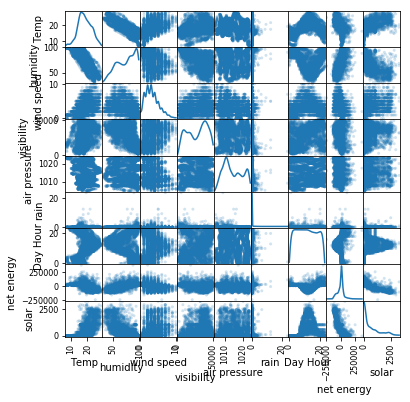

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

#Merge energy and solar energy produced into feature array
mergedMatrix = np.c_[featureArray,labels,labels_solar]
#Create a pandas dataframe for viz
scatterMatrix = mergedMatrix[:,2:].astype(float)
df = pd.DataFrame(data = scatterMatrix,
                  columns = ['Temp','humidity',
                              'wind speed','visibility',
                              'air pressure','rain','Day Hour',
                              'net energy','solar']
                 )

pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')

## Creating a regression model

At this point, we have a clean feature matrix (split into 3 sets) with the corresponding set of labels. Define a helper function to calculate the prediction error for validations and test sets. Define another function that normalizes the feature vector columns. 

Finally use the regression model from scikit-learn to fit training data. Tweak parameters and check their effect by calculating the prediction error for the validation set.

When the best set of parameters are found, check the prediction error on the test-set.

In [16]:
def prediction_error(labels_predict,labels_true):
    """
    Calculates the prediction error as the average absolute difference 
    between predicted and true labels
    
    """
    error = 0
    for predicted,true in zip(labels_predict,labels_true):
        print('True : {} Predicted : {}'.format(true,predicted))
        error += abs(predicted-true)
    
    error = error/len(labels_predict)
    return error

def normalize_data(data):
    """
    Scales data to [-1,1], to be done before feeding it for regression
    
    """
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler.transform(data)


# SGD Regression
X_train = normalize_data(data_train[:,2:].astype(float))
X_val = normalize_data(data_val[:,2:].astype(float))
X_test = normalize_data(data_test[:,2:].astype(float))

clf = linear_model.SGDRegressor(max_iter = 10**6/X_train.shape[0],
                                tol = 1e-6,
                                alpha = 0.0001,
                                )
clf.fit(X_train,labels_train)

print(clf.coef_)

print(prediction_error(clf.predict(X_val),labels_val))
print(prediction_error(clf.predict(X_test),labels_test))


[  79.43574638 -204.96141393  -37.63532297  -33.67105799   42.77886983
    6.71170678]
True : 0 Predicted : 273.60531706008294
True : 0 Predicted : 329.49607955791475
True : 0 Predicted : 289.0441690412315
True : 0 Predicted : 285.1975222616884
True : 0 Predicted : 307.7370746158397
True : 0 Predicted : 293.52581886389
True : 0 Predicted : 266.1616803410342
True : 0 Predicted : 215.74036206094837
True : 0 Predicted : 323.6550412856277
True : 0 Predicted : 341.8965825707775
True : 0 Predicted : 306.87675589394894
True : 0 Predicted : 280.27460710784067
True : 0 Predicted : 294.67844931007187
True : 0 Predicted : 364.90630191695595
True : 0 Predicted : 361.0649496437693
True : 0 Predicted : 353.0461261523212
True : 0 Predicted : 287.90237156011136
True : 0 Predicted : 202.86993600840742
True : 0 Predicted : 218.39726196876094
True : 0 Predicted : 214.20262936403122
True : 0 Predicted : 222.62030725475148
True : 0 Predicted : 179.87347983120122
True : 0 Predicted : 179.7226409558719
True 

In [15]:
# Ridge Regression
ridge = linear_model.Ridge(alpha=1.0)
ridge.fit(X_train,labels_train)
print(ridge.coef_)

print(prediction_error(ridge.predict(X_val),labels_val))
print(prediction_error(ridge.predict(X_test),labels_test))


[  79.52990817 -209.99680017  -37.70016195  -31.98678724   40.00927506
    8.61633434]
203.056153757
203.299853807
